<a href="https://colab.research.google.com/github/jtrinquier/SoftAlign/blob/main/Colab/SoftAlign_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import libraries

import pandas as pd
!  pip install git+https://github.com/deepmind/dm-haiku
! git clone https://github.com/jtrinquier/SoftAlign.git
import sys
import numpy as np
import string
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import pandas as pd
from jax.example_libraries.optimizers import adam
from jax.example_libraries.optimizers import sgd
import haiku as hk
import os
import re

softalign_path = os.path.join(os.getcwd(), 'SoftAlign')

# Add SoftAlign directory to sys.path if it's not already there
if softalign_path not in sys.path:
    sys.path.append(softalign_path)
softalign_code_path = os.path.join(softalign_path, 'softalign/colab')
if softalign_code_path not in sys.path:
    sys.path.append(softalign_code_path)
import Input_MPNN as input_
import END_TO_END_MODELS as ete
import Score_align as score_
import Score_align as lddt
import utils
import Loss_functions as loss_

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-mj0c2kl3
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-mj0c2kl3
  Resolved https://github.com/deepmind/dm-haiku to commit 879df61d51c01e247daf957e9ecf4c5d50d89e4a
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.15.dev0-py3-none-any.whl size=373959 sha256=83f820ac7f1f8dbdfc17e47ab2cd58a0eb0e012f7e735c7bd3abd85b09a9e81e
  Stored in directory: /tmp/pip-ephem-wheel-cache-w3roghi3/wheels/86/29/0a/454c478e7217c383ee3d05aa43cbeff48284c23430f59d0c4f
Successfully built dm-haiku
Cloning into 'SoftAlign'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 79 (delta 12), reused 7 (delta 4), pack-reused 52 (from 2)
Receiving objects: 100% (79/79), 4.34 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (25/25), done.


#tmalign

In [ ]:

!git clone https://github.com/kad-ecoli/TMalign.git
%cd TMalign
!g++ -O3 -ffast-math -lm -o TMalign TMalign.cpp
! g++ -O3 -ffast-math -lm -o TMscore TMscore.cpp
%cd ..


Cloning into 'TMalign'...
remote: Enumerating objects: 813, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 813 (delta 48), reused 50 (delta 26), pack-reused 737 (from 1)
Receiving objects: 100% (813/813), 1.05 MiB | 3.07 MiB/s, done.
Resolving deltas: 100% (574/574), done.
/content/TMalign
/content


In [ ]:
import os
def tmscore(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign/TMscore 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {}
  for line in output:
    line = line.rstrip()
    if line.startswith("RMSD"): o["rms"] = parse_float(line)
    if line.startswith("TM-score"): o["tms"] = parse_float(line)
    if line.startswith("GDT-TS-score"): o["gdt"] = parse_float(line)
  return o

In [ ]:
def tmalign(x,y):
  x,y = np.asarray(x),np.asarray(y)
  # save to dumpy pdb files
  for n,z in enumerate([x,y]):
    out = open(f"{n}.pdb","w")
    for k,c in enumerate(z):
      out.write("ATOM  %5d  %-2s  %3s %s%4d    %8.3f%8.3f%8.3f  %4.2f  %4.2f\n"
                  % (k+1,"CA","ALA","A",k+1,c[0],c[1],c[2],1,0))
    out.close()
  # pass to TMscore
  output = os.popen('./TMalign/TMalign 0.pdb 1.pdb')
  # parse outputs
  parse_float = lambda x: float(x.split("=")[1].split()[0])
  o = {"tms":[]}
  aln = []
  aln_mode = False
  for line in output:
    line = line.rstrip()
    if line.startswith("TM-score"): o["tms"].append(parse_float(line))
    if line.startswith('(":"'): aln_mode = True
    elif aln_mode == True and len(aln) < 3: aln.append(line)
    else: aln_mode = False

  o["aln"] = aln
  aln = []
  a,b = 0,0
  for n in range(len(o["aln"][0])):
    x = o["aln"][0][n]
    y = o["aln"][2][n]
    if x != "-":
      if y != "-": aln.append(b)
      else: aln.append(-1)
    if x != "-": a += 1
    if y != "-": b += 1

  o["aln"] = np.asarray(aln)
  return o

# Prepare the input, create train and test (different folds)
Training Data: SCOPE-Based Protein Alignments

This notebook uses a dataset of protein domain pairs derived from the SCOPE classification. Each row contains structural alignment information between two
domains.


In [ ]:
# @title Download training data

! pip install gdown
! gdown https://drive.google.com/uc?id=1uMNq5tR-IafDu9Pv3sgO0YWwZfvr_6Lu  # for files

training_data_path = "aln_SCOPE"

list_pairs_ = pd.read_csv(training_data_path,header = None,sep = ",")
(list_pairs_.head())

Downloading...
From (original): https://drive.google.com/uc?id=1uMNq5tR-IafDu9Pv3sgO0YWwZfvr_6Lu
From (redirected): https://drive.google.com/uc?id=1uMNq5tR-IafDu9Pv3sgO0YWwZfvr_6Lu&confirm=t&uuid=e85f48fd-d370-4578-9ebf-1316dc741045
To: /content/aln_SCOPE
100% 737M/737M [00:04<00:00, 152MB/s]


,0,1,2,3,4
0,a.1,d1dlwa_,d1dlwa_,1.00000,[ 0 1 2 3 4 5 6 7 8 9 10 ...
1,a.1,d1dlwa_,d2gkma_,0.93982,[ 12 13 14 15 16 17 18 19 20 21 22 ...
2,a.1,d1dlwa_,d2qrwa_,0.81432,[ 1 2 3 4 5 6 7 8 9 10 11 ...
3,a.1,d1dlwa_,d1s69a_,0.92695,[ 1 2 3 4 5 6 7 8 9 10 11 ...
4,a.1,d1dlwa_,d2bkma_,0.85270,[ 4 5 6 7 8 9 10 11 12 13 14 ...


🧬 Fold
The SCOPE fold classification of the protein domain pair.
Used to enforce disjoint train/test splits, ensuring that models generalize across structural families.

🔗 Protein1_ID / Protein2_ID
The SCOPE domain identifiers of the aligned protein structures.
These are the actual inputs to the alignment model.

📏 TM-score
A continuous metric between 0 and 1 measuring structural similarity between the two domains.
This is used to filter out low-confidence or non-homologous alignments during training.

📐 TM-align Alignment
The alignment indices obtained from TM-align, indicating which residues are matched.
These are used as supervision targets to train the model via cross-entropy loss.

📂 Train/Test Split — SCOPE Fold-Aware

To ensure robust generalization across structural classes, we construct a non-overlapping train/test split based on the SCOPE fold classification.

    🔹 Some folds are randomly selected for training.

    🔹 Remaining folds are reserved exclusively for testing.

    🔹 This guarantees that no structural fold class is shared between training and test sets.

<div style="margin-top: 1em; padding: 0.5em 1em; background-color: #fff9e6; border-left: 5px solid #f9c74f;"> <strong>Note:</strong> To ensure reproducibility with the results reported in the paper, <strong>do not change the random seed</strong> (<code>42</code>). </div>

In [ ]:
# @title Train/Test Split Setup (🔒 do not modify seed to match paper setup)

# Drop duplicate rows if any
list_pairs_ = list_pairs_.drop_duplicates()

df = list_pairs_
unique_values = df[0].unique()
# Fixed random seed for reproducibility
np.random.seed(42)

# Randomly select 1,000 folds for training
n = 1000
selected_values = np.random.choice(unique_values, n)
# Split train and test
list_pairs = df[df[0].isin(selected_values)]
list_pairs_test = df[~df[0].isin(selected_values)]

# Rename columns
list_pairs = list_pairs.rename(columns={0: "fold", 1: "name1", 2: "name2", 3: "TMS", 4: "aln"})
list_pairs_test = list_pairs_test.rename(columns={0: "fold", 1: "name1", 2: "name2", 3: "TMS", 4: "aln"})

# Reset indices
list_pairs = list_pairs.reset_index(drop=True)
list_pairs_test = list_pairs_test.reset_index(drop=True)

# Summary
print("✅ Train/Test split complete.")
print(f"Training folds: {list_pairs.fold.nunique()} | Proteins: {len(list_pairs['name1'].unique())}")
print(f"Test folds:     {list_pairs_test.fold.nunique()} | Proteins: {len(list_pairs_test['name1'].unique())}")


✅ Train/Test split complete.
Training folds: 681 | Proteins: 6506
Test folds:     513 | Proteins: 4705


🔬 Inputs of ProteinMPNN

The file dicti_inputs_SCOPE_colab contains preprocessed input features for protein domains, stored as a Python dictionary. This was generated from SCOPe40 PDB structures using the Input_MPNN module provided in the GitHub repository.

Each protein entry in the dictionary includes:

    Residue coordinates — 3D positions of backbone atoms (used as input to geometric models).

    Mask — (used in the original MPNN paper but not usefumlfor this work).

    Chain index — Denotes chain membership (used in the original MPNN paper but not useful for this work).

📌 Note:
If you want to use your own protein data, you’ll need to process your PDB files using the same Input_MPNN pipeline to generate a compatible dicti_inputs dictionary.

In [ ]:
# @title Inputs of ProteinMPNN
! gdown 1DFWcUgPukTxWGPUxaeTM1kNEVNCkRgbO
import pickle
with open("dicti_inputs_SCOPE_colab",'rb') as fff:
  dicti_inputs = pickle.load(fff)

Downloading...
From (original): https://drive.google.com/uc?id=1DFWcUgPukTxWGPUxaeTM1kNEVNCkRgbO
From (redirected): https://drive.google.com/uc?id=1DFWcUgPukTxWGPUxaeTM1kNEVNCkRgbO&confirm=t&uuid=5e76ed11-6ed3-435a-81ae-eeebf1834774
To: /content/dicti_inputs_SCOPE_colab
100% 236M/236M [00:04<00:00, 57.4MB/s]


In [ ]:
#@title Input of the model

max_size = 300  #@param {type:"integer"}
threshold = 0.5  #@param

def prepare_input_data(pairs_df, inputs_dict, max_len):
    X1 = []; X2 = []
    mask1 = []; mask2 = []
    chain1 = []; chain2 = []
    res1 = []; res2 = []
    id1 = []
    id2 = []
    tmaln = []

    for k in range(len(pairs_df)):
        pr1, pr2 = pairs_df["name1"][k], pairs_df["name2"][k]
        if pr1 in inputs_dict and pr2 in inputs_dict and pairs_df["TMS"][k] > threshold:
            _X1, _mask1, _chain1, _res1 = inputs_dict[pr1]
            _X2, _mask2, _chain2, _res2 = inputs_dict[pr2]
            if len(_X1[0]) <= max_len and len(_X2[0]) <= max_len:
                id1.append(pr1)
                id2.append(pr2)
                X1.append(_X1[0]); X2.append(_X2[0])
                mask1.append(_mask1[0]); mask2.append(_mask2[0])
                chain1.append(_chain1[0]); chain2.append(_chain2[0])
                res1.append(_res1[0]); res2.append(_res2[0])
                aln_indices = np.array([int(s) for s in re.findall(r'-?\d+', pairs_df["aln"][k])])
                tmaln.append(aln_indices)

    return X1, X2, mask1, mask2, chain1, chain2, res1, res2, id1, id2, tmaln

# Prepare training inputs
X1, X2, mask1, mask2, chain1, chain2, res1, res2, id1, id2, tmaln = prepare_input_data(list_pairs, dicti_inputs, max_size)

# Prepare test inputs
X1tt, X2tt, mask1tt, mask2tt, chain1tt, chain2tt, res1tt, res2tt, id1tt, id2tt, tmalntt = prepare_input_data(list_pairs_test, dicti_inputs, max_size)

print(f"Training pairs prepared: {len(id1)}")
print(f"Test pairs prepared: {len(id1tt)}")

nb_test = 2 #not used, no overfitting
tmaln = np.array(tmaln,dtype=object)
bs = 15
dicti_train_test = utils.create_test_train(np.array(id1),np.array(id2),np.array(X1,dtype=object),np.array(X2,dtype=object),np.array(chain1,dtype=object),np.array(chain2,dtype=object),np.array(mask1,dtype=object),np.array(mask2,dtype=object),np.array(res1,dtype=object),np.array(res2,dtype=object),nb_test = nb_test,tma = True,tmaln = tmaln)


Training pairs prepared: 308571
Test pairs prepared: 118769
308571
nb of training pairs 307840


# Initialization

🧠 Model: Differentiable Structural Alignment

This model learns pairwise protein structural alignment using differentiable alignment heads. Two alignment mechanisms are supported:

    Soft Smith-Waterman (SSW)

    Softmax Matching

Both alignment approaches are fully differentiable and trained end-to-end.
⚙️ Optional: Categorical Alignment

You can enable a categorical version of the model by setting categorical = True. In this mode:

    Each position is mapped to a discrete value via cluster assignments.

    You can set the number of clusters via nb_clusters.

⚠️ Note: Categorical training is less stable. We recommend first training the continuous version and initializing clusters via k-means, as described in the paper.

📓 A helper notebook to guide this process (continuous → cluster initialization) will be released soon.

In [ ]:
# @title Define model

num_layers = 3
num_neighbors = 64
encoding_dim = 64
categorical = False     #@param {type:"boolean"}
nb_clusters = 20        #@param {type:"integer"}
soft_max = False         #@param {type:"boolean"}

def model_end_to_end(
    x1, x2, lens, t,
    node_features=encoding_dim,
    edge_features=encoding_dim,
    hidden_dim=encoding_dim,
    num_encoder_layers=num_layers,
    k_neighbors=num_neighbors,
    categorical=categorical,
    nb_clusters=nb_clusters,
    affine=True,
    soft_max=soft_max
):
    if categorical:
        model = ete.END_TO_END_SEQ_KMEANS(
            node_features=node_features,
            edge_features=edge_features,
            hidden_dim=hidden_dim,
            num_encoder_layers=num_encoder_layers,
            k_neighbors=k_neighbors,
            nb_clusters=nb_clusters,
            affine=affine,
            soft_max=soft_max,
            dropout=0.0
        )
    else:
        model = ete.END_TO_END(
            node_features=node_features,
            edge_features=edge_features,
            hidden_dim=hidden_dim,
            num_encoder_layers=num_encoder_layers,
            k_neighbors=k_neighbors,
            affine=affine,
            soft_max=soft_max,
            dropout=0.0
        )
    return model(x1, x2, lens, t)





X_1,X_2,chain_1,chain_2,mask_1,mask_2,res_1,res_2,tmaln = dicti_train_test["train"]


MODEL_ETE = hk.transform(model_end_to_end)
key = jax.random.PRNGKey(0)
X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens = utils.pad_(X_1[:bs],mask_1[:bs],res_1[:bs],chain_1[:bs],X_2[:bs],mask_2[:bs],res_2[:bs],chain_2[:bs],max_size)
x1 = X1,mask1,res1,chain1
x2 = X2,mask2,res2,chain2

In [ ]:
# @title Init params (put learning rate to a smaller value if categorical)
learning_rate = 1/1e3 #@param

params = MODEL_ETE.init(key,x1,x2,lens,1)

opt_init, opt_update, get_params = adam(learning_rate)
opt_state = opt_init(params)

if categorical:
  @jax.jit
  def train_step(step_i, opt_state, loss_data):
      net_params = get_params(opt_state)
      (loss,aux), grads = jax.value_and_grad(loss_.CrossEntropyLoss_CAT, argnums=0,has_aux=True)(net_params, loss_data,MODEL_ETE)

      return (loss,aux), opt_update(step_i, grads, opt_state)
else:
  @jax.jit
  def train_step(step_i, opt_state, loss_data):
      net_params = get_params(opt_state)
      (loss,aux), grads = jax.value_and_grad(loss_.CrossEntropyLoss, argnums=0,has_aux=True)(net_params, loss_data,MODEL_ETE)

      return (loss,aux), opt_update(step_i, grads, opt_state)

# Training


 Training Loop

This section trains the differentiable protein alignment model over a set number of epochs. The key components of the loop are:
🔧 Settings

    Epochs: Number of full training passes over the dataset.

    Temperature Annealing: The temperature parameter T linearly decreases from T_start to T_end, controlling the sharpness of the alignment softmax or soft SWW.

    Batch Sampling: Random batches of fixed size (bs) are sampled in each epoch.

In [ ]:
#@title Training
import time

np.random.seed()  # Use system time for randomness

# Hyperparameters
epochs = 50  #@param {type:"integer"}
T_start = 3  #@param {type:"number"}
T_end = 1    #@param {type:"number"}

bs = 20  # Batch size
nb_batches = len(X_1) // bs - 1

for epoch in range(epochs):
    start_time = time.time()

    # Linearly decay temperature
    T = T_start - (epoch / epochs) * (T_start - T_end)
    print(f"\n🧊 Epoch {epoch+1}/{epochs} — Temperature: {T:.2f}")

    losses = []
    batch_indices = np.random.randint(0, nb_batches, 500)

    for k, i in enumerate(batch_indices):
        # Prepare input batch
        X1, mask1, res1, chain1, X2, mask2, res2, chain2, TMALN, lens = utils.pad_tmalign(
            X_1[i*bs:(i+1)*bs],
            mask_1[i*bs:(i+1)*bs],
            res_1[i*bs:(i+1)*bs],
            chain_1[i*bs:(i+1)*bs],
            X_2[i*bs:(i+1)*bs],
            mask_2[i*bs:(i+1)*bs],
            res_2[i*bs:(i+1)*bs],
            chain_2[i*bs:(i+1)*bs],
            tmaln[i*bs:(i+1)*bs],
            max_size
        )

        # Optional pairwise masks (not currently used)
        mask__1 = np.zeros((bs, max_size, max_size))
        mask__2 = np.zeros((bs, max_size, max_size))
        for jj in range(X1.shape[0]):
            mask__1[jj, :lens[jj, 0], :lens[jj, 0]] = 1
            mask__2[jj, :lens[jj, 1], :lens[jj, 1]] = 1

        x = (X1, mask1, res1, chain1,
             X2, mask2, res2, chain2,
             TMALN, lens, T)

        # Training step
        (loss, aux), opt_state = train_step(epoch, opt_state, x)
        losses.append(loss)

        # Debug info
        if (k + 1) % 25 == 0:
            print(f"   • Batch {k+1}/{len(batch_indices)} — Loss: {loss:.4f}")
            if categorical:
                print("     Predicted cluster sequence (first sample):")
                print(np.argmax(aux["seqs"][0][0], axis=-1))

    epoch_loss = jnp.array(losses).mean()
    print(f"✅ Epoch {epoch+1} complete — Mean loss: {epoch_loss:.4f} — Time: {time.time() - start_time:.1f}s")



🧊 Epoch 1/50 — Temperature: 3.00
   • Batch 25/500 — Loss: 714.0546
   • Batch 50/500 — Loss: 751.3472
   • Batch 75/500 — Loss: 704.4214
   • Batch 100/500 — Loss: 616.5635
   • Batch 125/500 — Loss: 601.2910
   • Batch 150/500 — Loss: 542.0822
   • Batch 175/500 — Loss: 567.8313
   • Batch 200/500 — Loss: 320.1154
   • Batch 225/500 — Loss: 341.6186
   • Batch 250/500 — Loss: 385.4583
   • Batch 275/500 — Loss: 468.3280
   • Batch 300/500 — Loss: 388.2556
   • Batch 325/500 — Loss: 272.8908
   • Batch 350/500 — Loss: 427.9413
   • Batch 375/500 — Loss: 316.5945
   • Batch 400/500 — Loss: 339.7700
   • Batch 425/500 — Loss: 302.0251
   • Batch 450/500 — Loss: 290.1823
   • Batch 475/500 — Loss: 396.2198
   • Batch 500/500 — Loss: 256.7597
✅ Epoch 1 complete — Mean loss: 451.5559 — Time: 385.4s

🧊 Epoch 2/50 — Temperature: 2.96
   • Batch 25/500 — Loss: 406.6148
   • Batch 50/500 — Loss: 272.6440
   • Batch 75/500 — Loss: 301.8337
   • Batch 100/500 — Loss: 301.6341
   • Batch 125/500

In [ ]:
params = get_params(opt_state)


# True test, different folds

In [ ]:
#@title Test set

import LDDT_LOSS as lddt
t = 10**-4
@jax.jit
def align(input_data,weights):
  X1,mask1,res1,chain1,X2,mask2,res2,chain2,lens,t = input_data
  x1 = X1,mask1,res1,chain1
  x2 = X2,mask2,res2,chain2
  return MODEL_ETE.apply(weights,key, x1,x2,lens,t)[0],MODEL_ETE.apply(weights,key, x1,x2,lens,t)[1]
import random

import Score_align as score_
n_samples = 1000
random.seed(123)  # fix the seed to 123 for reproducibility
print(len(X1tt))
indices = random.sample(range(len(X1tt)), n_samples)
X_1t = [X1tt[i] for i in indices]
X_2t = [X2tt[i] for i in indices]
chain_1t = [chain1tt[i] for i in indices]
chain_2t = [chain2tt[i] for i in indices]
mask_1t = [mask1tt[i] for i in indices]
mask_2t = [mask2tt[i] for i in indices]
res_1t = [res1tt[i] for i in indices]
res_2t = [res2tt[i] for i in indices]
tmalnt = [tmalntt[i] for i in indices]



k = 1000
bs = 50
params = get_params(opt_state)
max_size2 = 300
max_size = 300
X1,mask1,res1,chain1,X2,mask2,res2,chain2,TMALN,lens = utils.pad_tmalign(X_1t,mask_1t,res_1t,chain_1t,X_2t,mask_2t,res_2t,chain_2t,tmalnt,max_size2)
print(len(mask_2t),len(tmalnt))
print(len(X1))

score_reconstruc = np.zeros(k)
score_tm = np.zeros(k)
score_reconstruc_lddt = np.zeros(k)
score_tm_lddt = np.zeros(k)

for i in range(k//bs):
#for i in range(2):
  #print(i)
  input_data = X1[i*bs:(i+1)*bs],mask1[i*bs:(i+1)*bs],res1[i*bs:(i+1)*bs],chain1[i*bs:(i+1)*bs],X2[i*bs:(i+1)*bs],mask2[i*bs:(i+1)*bs],res2[i*bs:(i+1)*bs],chain2[i*bs:(i+1)*bs],lens[i*bs:(i+1)*bs],t
  soft_aln,sim = align(input_data,params)
  soft_aln = np.array(soft_aln)
  soft_aln[soft_aln<10**-2] = 0
  soft_aln = jnp.array(soft_aln)

  mask__1 = np.zeros((bs,max_size,max_size))
  mask__2 = np.zeros((bs,max_size,max_size))
  for j in range(bs):

      mask__1[j,:lens[i*bs+j,0],:lens[i*bs+j,0]] = 1
      mask__2[j,:lens[i*bs+j,1],:lens[i*bs+j,1]] = 1
  score_reconstruc_lddt[i*bs:(i+1)*bs] = lddt.get_LDDTloss(X1[i*bs:(i+1)*bs][:,:,1],X2[i*bs:(i+1)*bs][:,:,1],soft_aln,lens[i*bs:(i+1)*bs],mask__1,mask__2,t, max1 = max_size)
  score_tm_lddt[i*bs:(i+1)*bs] = lddt.get_LDDTloss(X1[i*bs:(i+1)*bs][:,:,1],X2[i*bs:(i+1)*bs][:,:,1],jax.nn.one_hot(TMALN[i*bs:(i+1)*bs],max_size),lens[i*bs:(i+1)*bs],mask__1,mask__2,t, max1 = max_size)

  for j in range(bs):

    temp1 = tmscore(X_1t[i*bs+j][:,1],jax.nn.one_hot(TMALN[i*bs+j][:lens[i*bs+j][0]],lens[i*bs+j][1])@X_2t[i*bs+j][:,1])
    score_tm[j+i*bs] = temp1["tms"]
    temp2 = tmscore(X_1t[i*bs+j][:,1],soft_aln[j,:lens[i*bs+j][0],:lens[i*bs+j][1]]@X_2t[i*bs+j][:,1])
    score_reconstruc[j+i*bs] = temp2["tms"]

118769
1000 1000
1000


In [ ]:
print(score_reconstruc_lddt[score_tm>0.6].mean())

0.5607897444278933


In [ ]:
print(score_tm_lddt[score_tm>0.6].mean())

0.5690648442832753


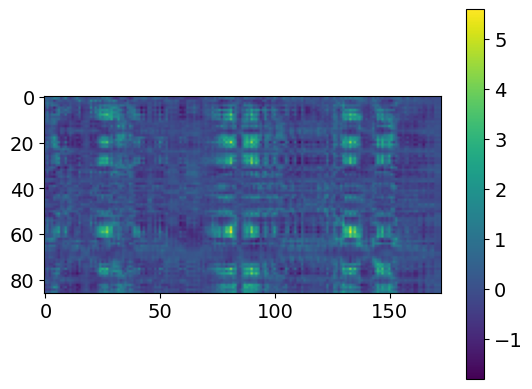

In [ ]:
#one example of similarity matrix
plt.imshow(sim[j, :lens[i * bs + j][0], :lens[i * bs + j][1]])
plt.colorbar()

Text(0.5, 1.0, 'Tm-align alignment')

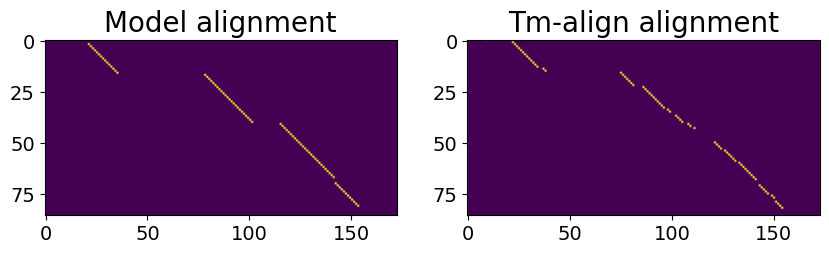

In [ ]:
#one example of alignement
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, this is the first subplot
plt.imshow(soft_aln[j, :lens[i * bs + j][0], :lens[i * bs + j][1]])
plt.title("Model alignment")

# Set up the second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, this is the second subplot
plt.imshow(jax.nn.one_hot(TMALN[i * bs + j][:lens[i * bs + j][0]], lens[i * bs + j][1]))
plt.title("Tm-align alignment")

0.4811372562199831 0.48882065147161485


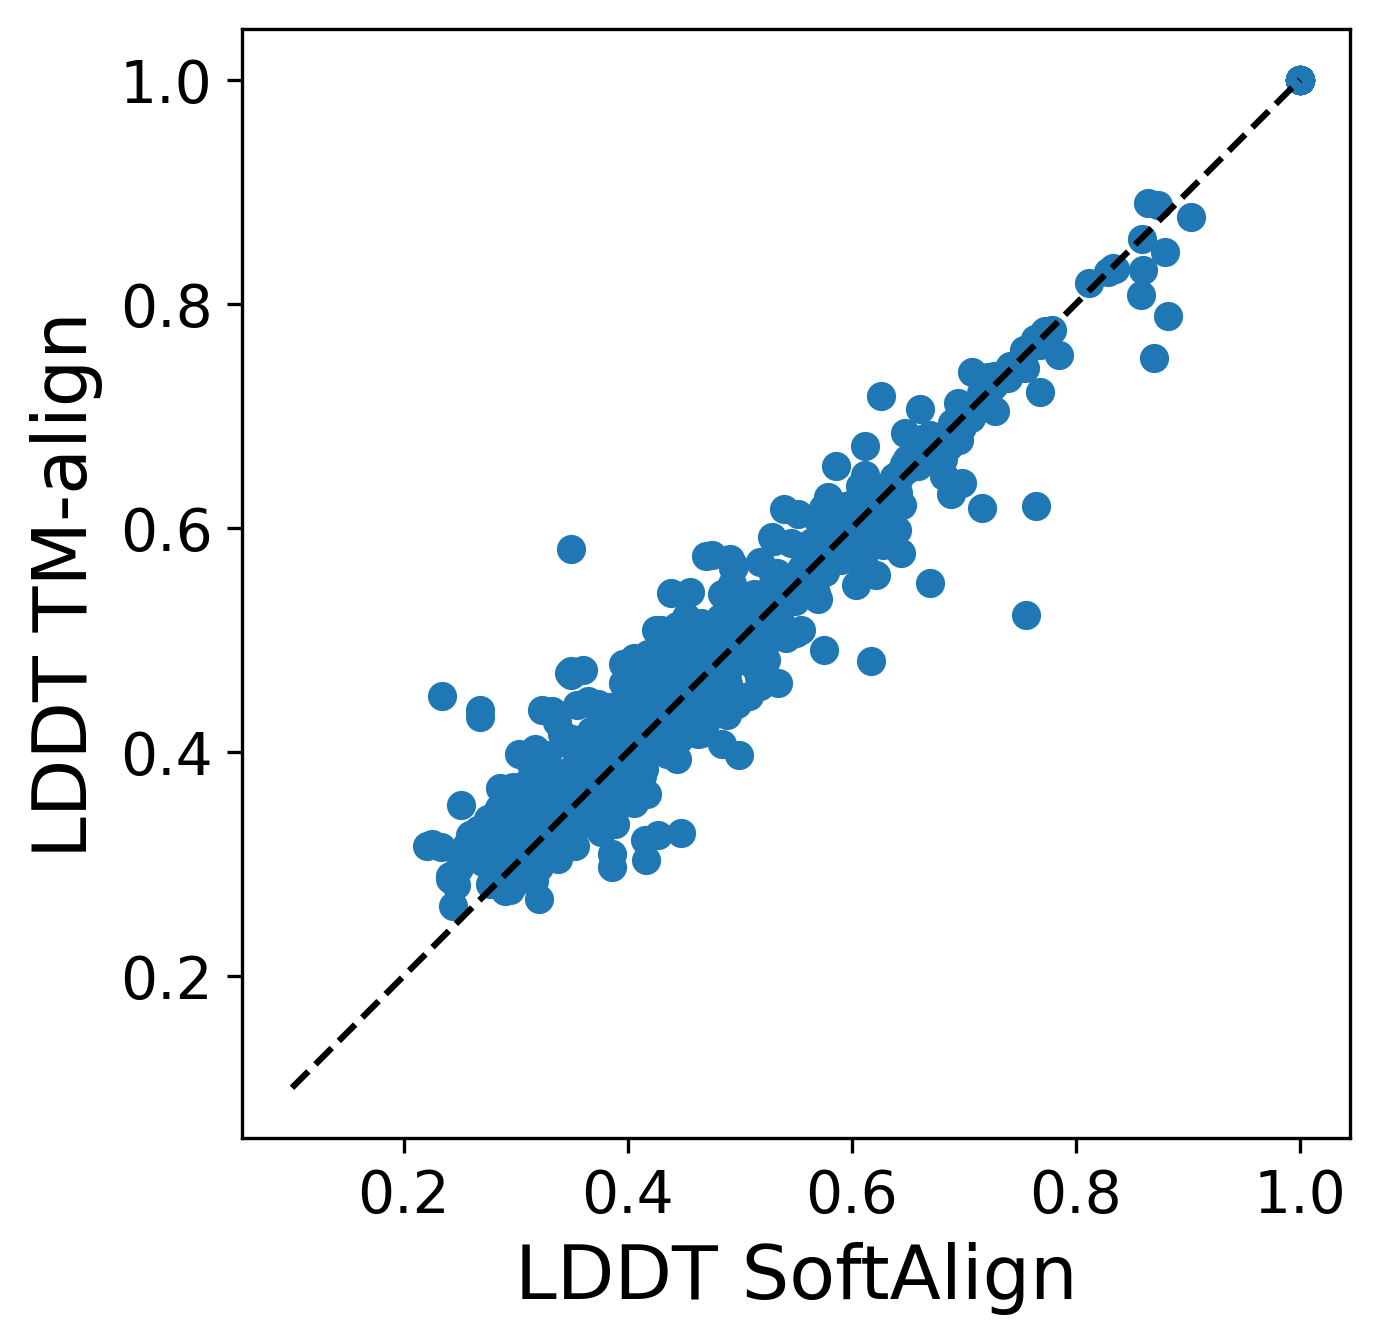

In [ ]:
import matplotlib.pyplot as plt
# Set global font sizes
plt.rcParams.update({
    'font.size': 16,           # General font size
    'axes.titlesize': 20,      # Title font size
    'axes.labelsize': 18,      # Axis label font size
    'xtick.labelsize': 14,     # X-tick label font size
    'ytick.labelsize': 14,     # Y-tick label font size
    'legend.fontsize': 16,     # Legend font size
})

# Create the main figure and plot
plt.figure(dpi=300)
plt.scatter(score_reconstruc_lddt,score_tm_lddt)
print(score_reconstruc_lddt.mean(),score_tm_lddt.mean())
plt.xlabel("LDDT SoftAlign")
plt.ylabel("LDDT TM-align")
plt.plot([0.1,1],[0.1,1],"--k")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
# Set the aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

0.5784957 0.6320934


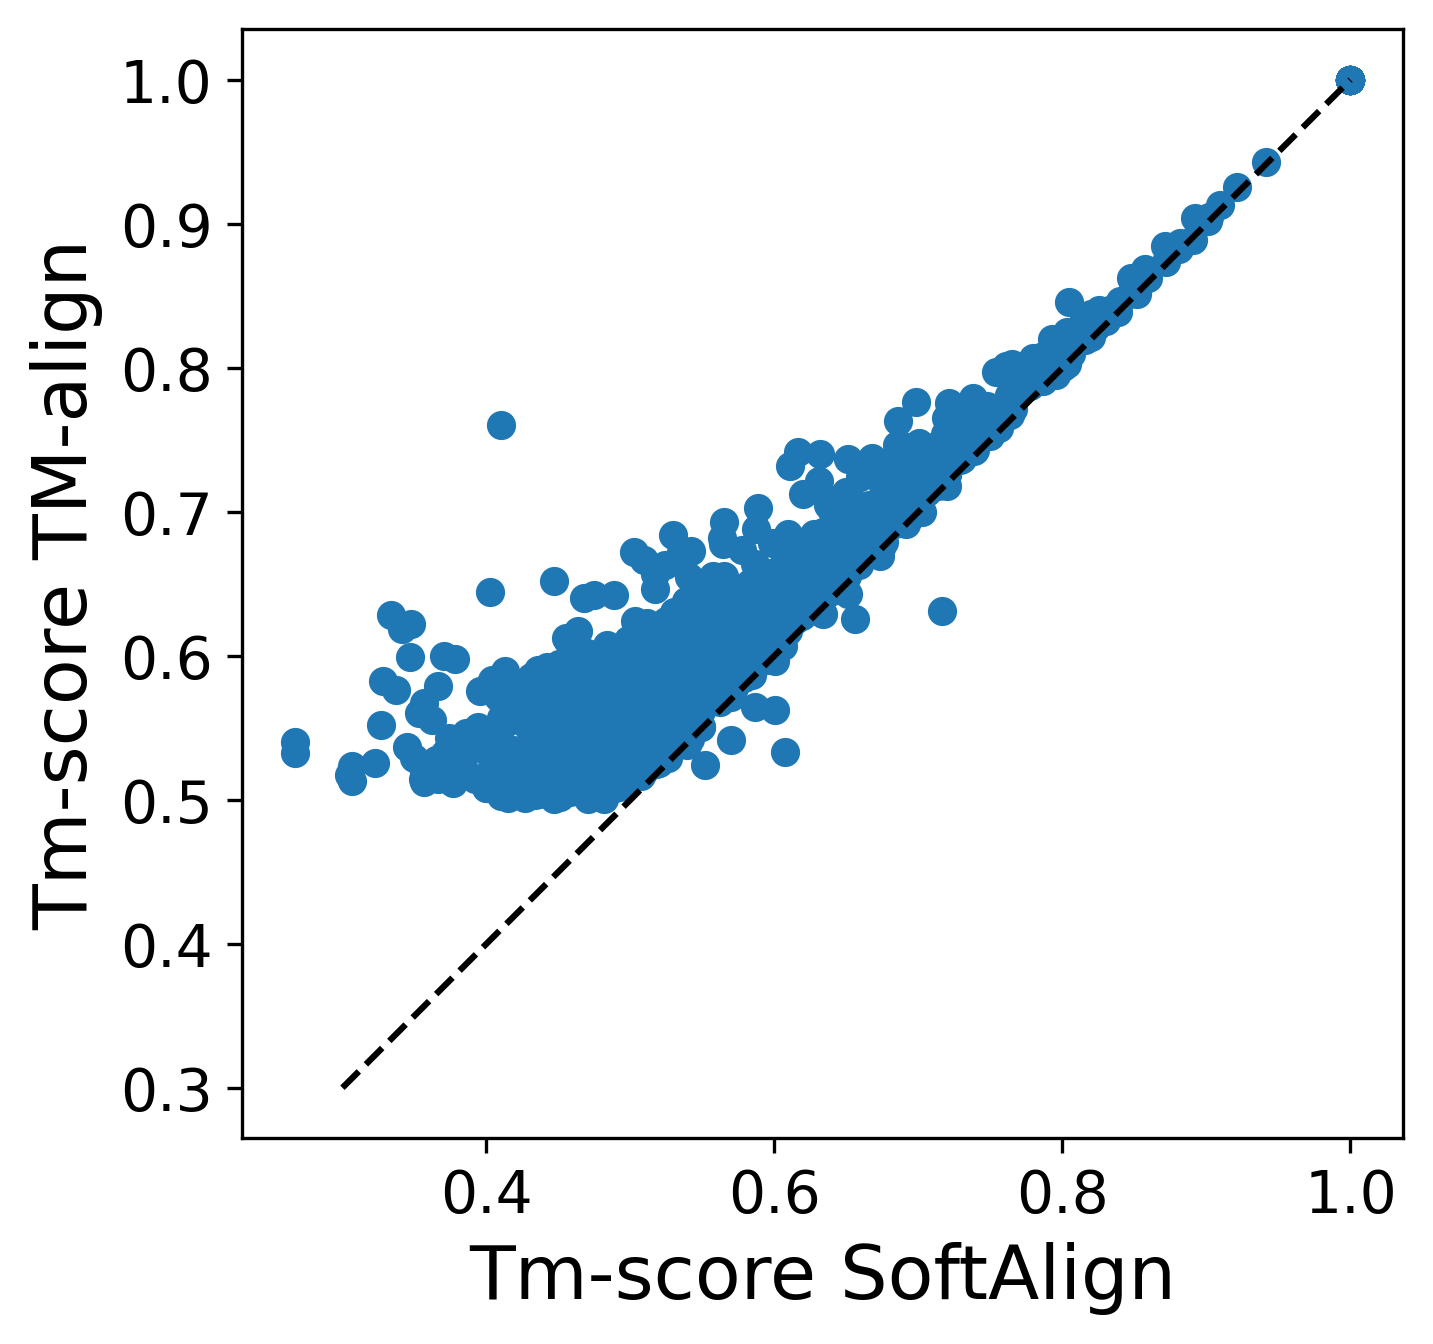

In [ ]:
plt.figure(dpi = 300)
plt.scatter(score_reconstruc,score_tm)
print(score_reconstruc.mean(),score_tm.mean())
#square = patches.Rectangle((0.6, 0.6), 0.4, 0.4, linewidth=1, edgecolor='r', facecolor='none')
#plt.gca().add_patch(square)

plt.xlabel("Tm-score SoftAlign")
plt.ylabel("Tm-score TM-align")
plt.plot([0.3,1],[0.3,1],"--k")
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_aspect('equal', adjustable='box')